In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.optimize import curve_fit
import math
%matplotlib nbagg

In [20]:
#import gamma raw data
file_name="EJ301_Co60_60s.h5"
data=h5py.File(file_name,"r")
event_data=data["event_data"]
gamma_raw_data=np.array(data["raw_data"])
gamma_raw_data=np.float32(gamma_raw_data)

#import neutron raw data
file_name="EJ301_Cf252_60s.h5"
data=h5py.File(file_name,"r")
event_data=data["event_data"]
neutron_raw_data=np.array(data["raw_data"])
neutron_raw_data=np.float32(neutron_raw_data)

<IPython.core.display.Javascript object>


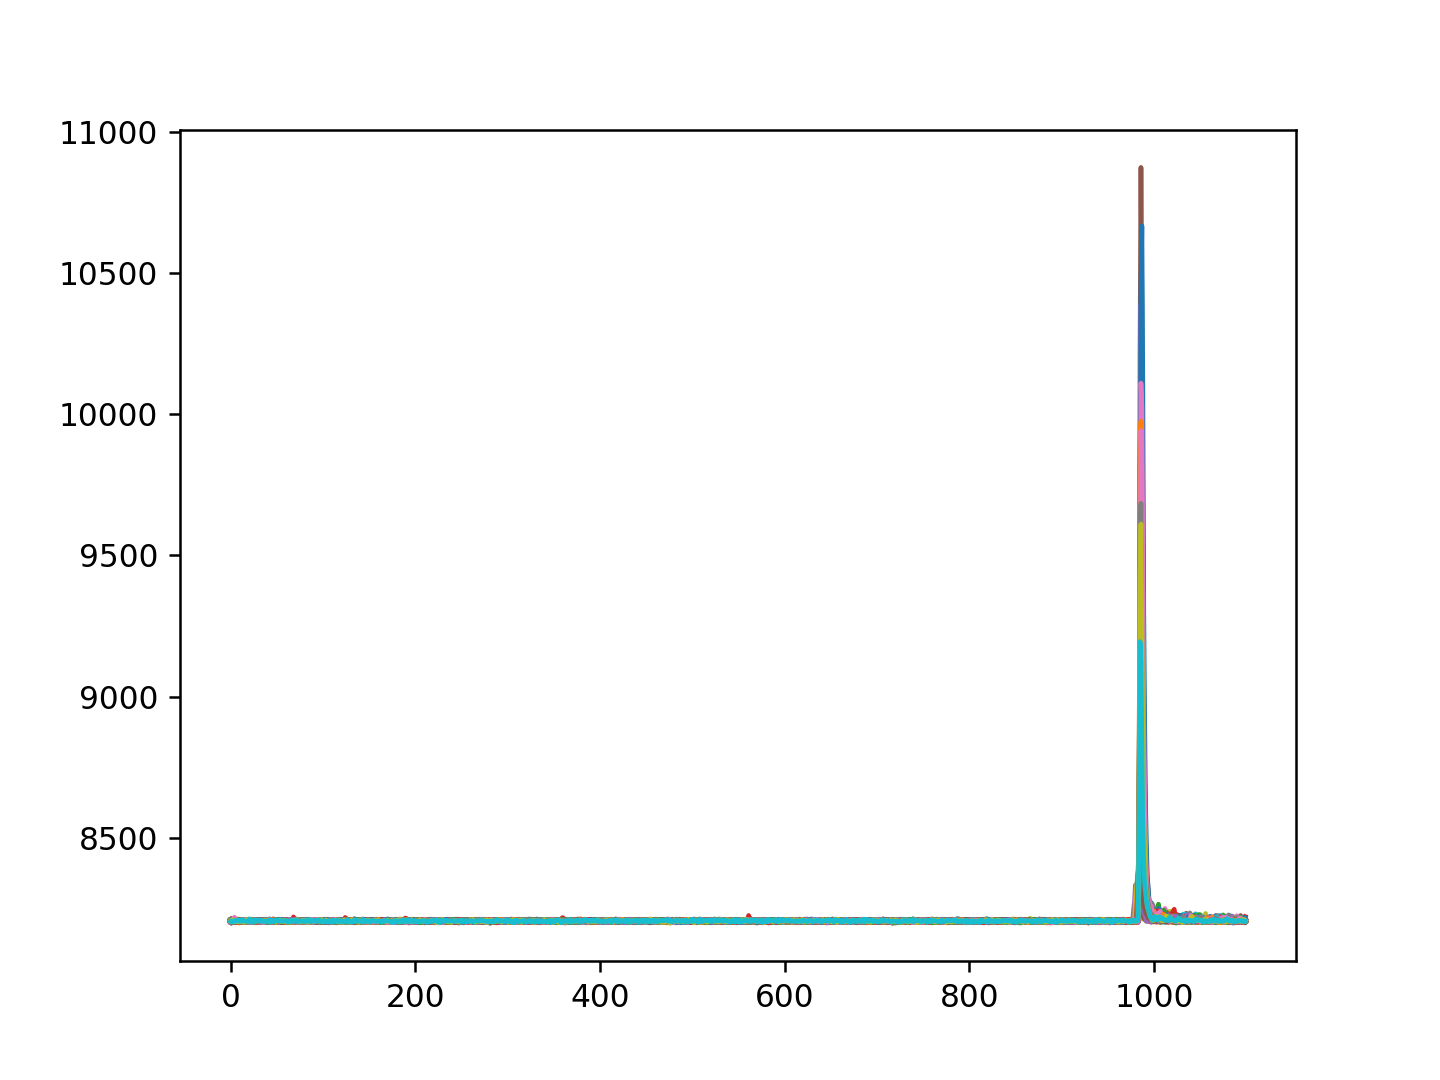

In [4]:
#check waveforms
waveform_data=gamma_raw_data[0:100]
plt.figure("Waveforms")
for i in waveform_data:
    plt.plot(i)

In [21]:
#take first x events
gamma_data=gamma_raw_data[:]
neutron_data=neutron_raw_data[:]

In [22]:
# subtract off baselines
baseline=np.mean(gamma_data[:,0:900],axis=1)
gamma_baseline_data=gamma_data-baseline[:,None]
gamma_baseline_data=gamma_baseline_data[:,950:1050]
baseline=np.mean(neutron_data[:,0:900],axis=1)
neutron_baseline_data=neutron_data-baseline[:,None]
neutron_baseline_data=neutron_baseline_data[:,950:1050]

print("Shape of Gamma Ray Data:")
print(np.shape(gamma_baseline_data))
print()
print("Shape of Neutron Data:")
print(np.shape(neutron_baseline_data))

Shape of Gamma Ray Data:
(43536, 100)

Shape of Neutron Data:
(167477, 100)


In [23]:
# create the threshold data sets
channel_threshold=100

mask=np.max(gamma_baseline_data,axis=1)>channel_threshold
gamma_threshold_data=gamma_baseline_data[mask]

mask=np.max(neutron_baseline_data,axis=1)>channel_threshold
neutron_threshold_data=neutron_baseline_data[mask]

print("Number of Gamma Events Removed:")
print(np.shape(gamma_baseline_data)[0]-np.shape(gamma_threshold_data)[0])
print()
print("Number of Neutron Events Removed:")
print(np.shape(neutron_baseline_data)[0]-np.shape(neutron_threshold_data)[0])

Number of Gamma Events Removed:
5

Number of Neutron Events Removed:
641


<IPython.core.display.Javascript object>


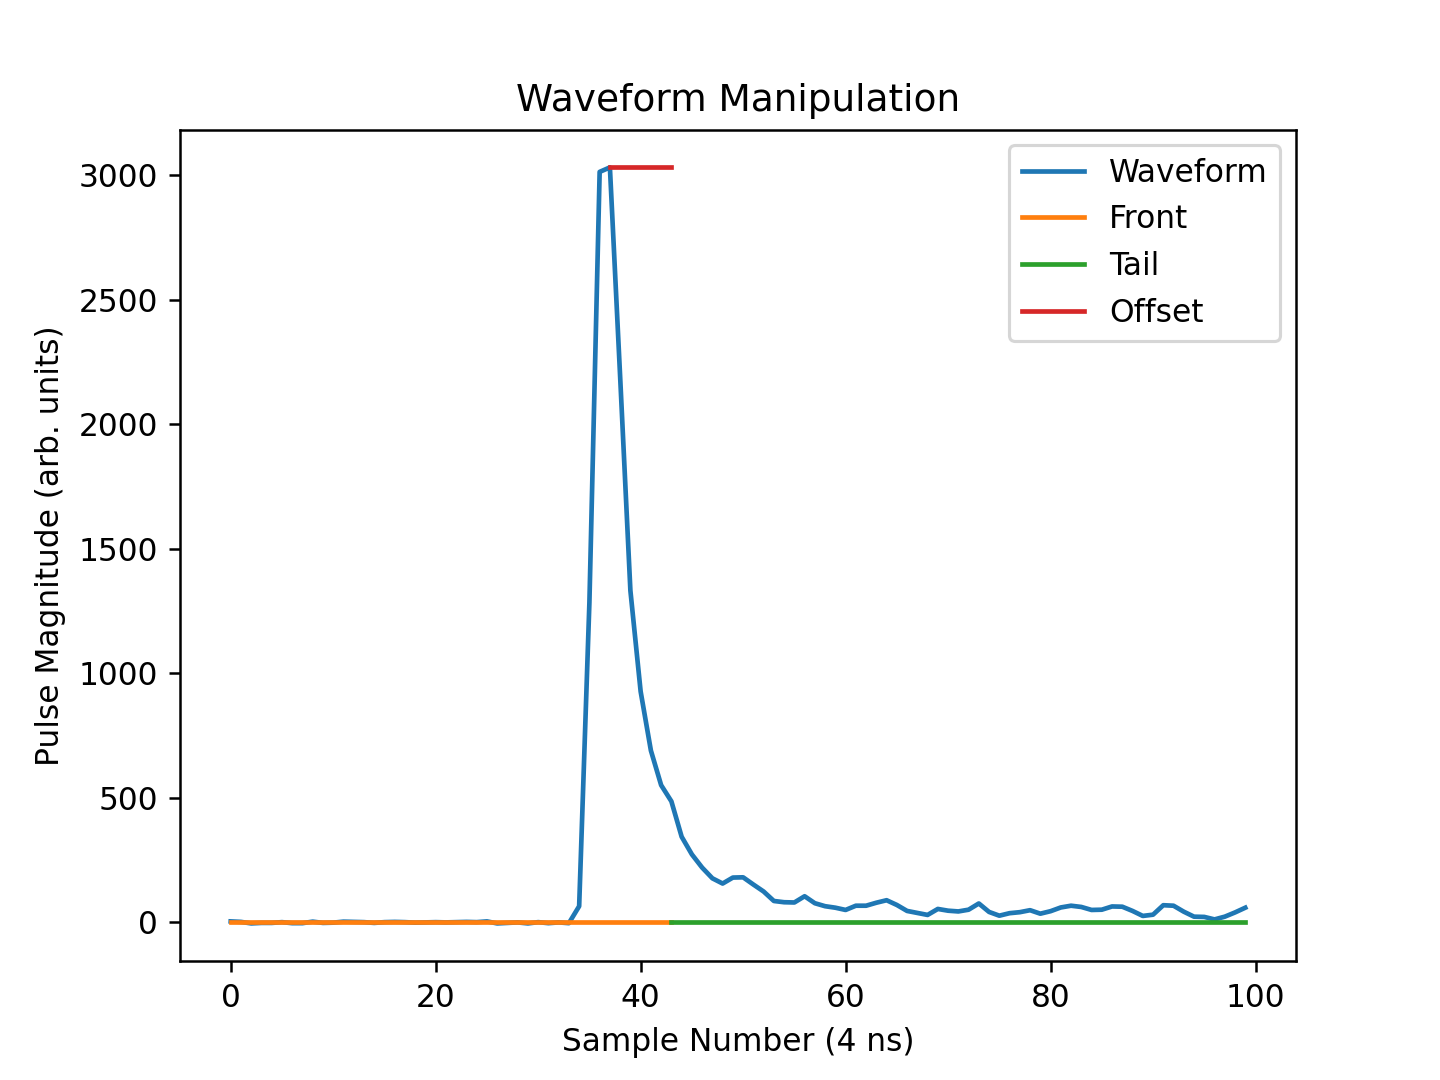

Text(0.5, 1.0, 'Waveform Manipulation')

In [8]:
# depiction of waveform treatment
ex_offset=7

plt.figure("PSD Waveforms 1")

wf_ex=neutron_threshold_data[0]


plt.plot(wf_ex)
    
plt.plot(np.zeros(np.argmax(wf_ex)+ex_offset))
plt.plot(np.arange(np.argmax(wf_ex)+ex_offset-1,len(wf_ex)),np.zeros(len(wf_ex)-np.argmax(wf_ex)-ex_offset+1))
plt.plot(np.arange(np.argmax(wf_ex),np.argmax(wf_ex)+ex_offset),np.max(wf_ex)*np.ones(ex_offset))
plt.legend(["Waveform","Front","Tail","Offset"])
plt.xlabel("Sample Number (4 ns)")
plt.ylabel("Pulse Magnitude (arb. units)")
plt.title("Waveform Manipulation")

<IPython.core.display.Javascript object>


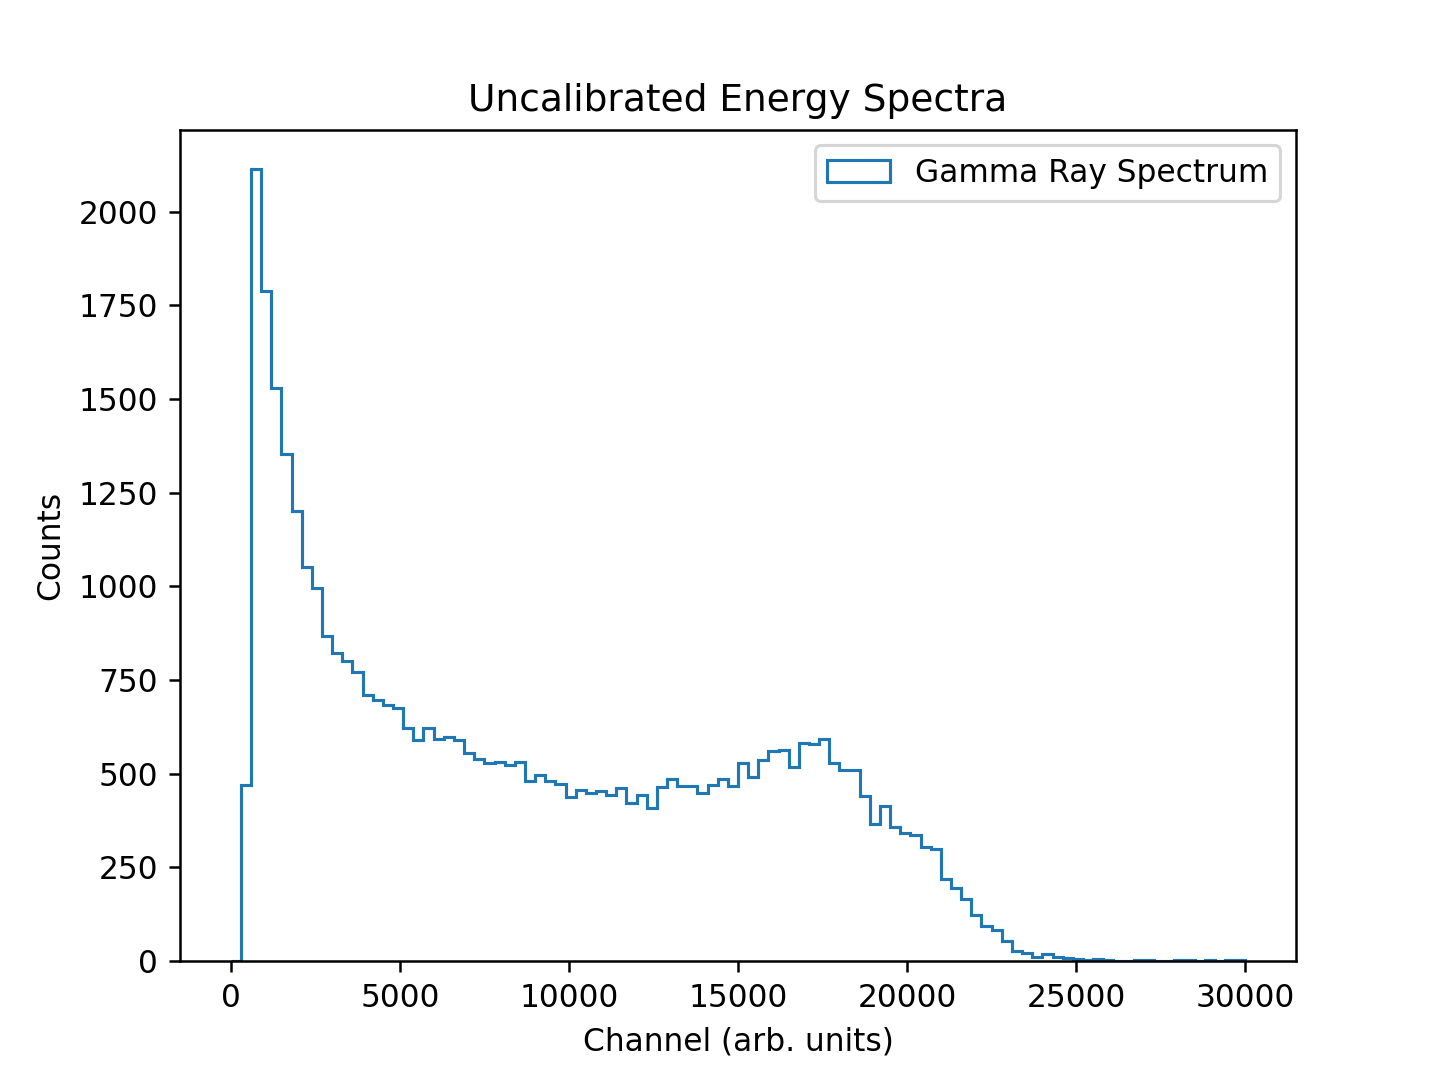

Text(0.5, 1.0, 'Uncalibrated Energy Spectra')

In [25]:
#plot spectra
plt.figure("Spectra")
gamma_histogram=plt.hist(np.sum(gamma_baseline_data,axis=1),bins=100,histtype='step',range=[0,30000])
gamma_hist_values=gamma_histogram[0]
gamma_hist_bins=gamma_histogram[1]
gamma_hist_bins=0.5*(gamma_hist_bins[1:]+gamma_hist_bins[:-1])
# neutron_histogram=plt.hist(np.sum(neutron_baseline_data,axis=1),bins=100,histtype='step',range=[0,20000])
# neutron_hist_values=neutron_histogram[0]
# neutron_hist_bins=neutron_histogram[1]
# neutron_hist_bins=0.5*(neutron_hist_bins[1:]+neutron_hist_bins[:-1])
# plt.yscale('log')
plt.xlabel("Channel (arb. units)")
plt.ylabel("Counts")
plt.title("Uncalibrated Spectra")
plt.legend(["Gamma Ray Spectrum","Neutron Spectrum"])
plt.title("Uncalibrated Energy Spectra")


<IPython.core.display.Javascript object>


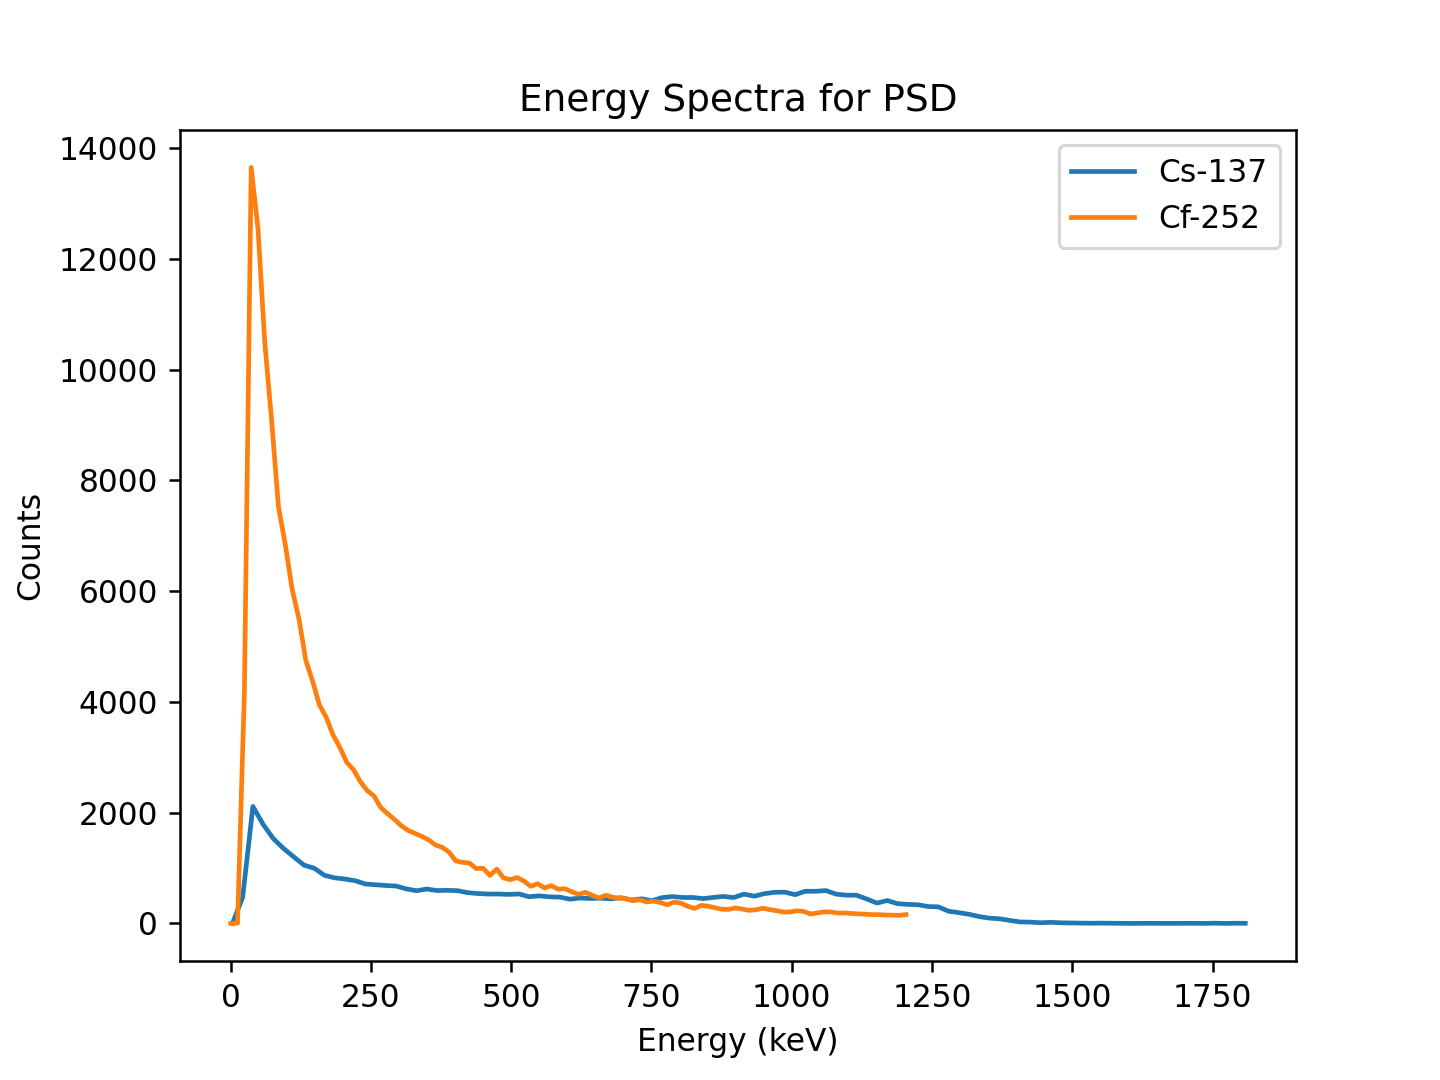

In [26]:
#calibrate energy spectra

#define the calibrationg (easier to do by hand)
energy_calib=[0,482,1070]
channel_calib=[0,8200.5,17620]

coeff=np.polyfit(channel_calib,energy_calib,1)

plt.figure("Energy Calibrated Spectrum")
gamma_hist_energies=gamma_hist_bins*coeff[0]+coeff[1]
plt.plot(gamma_hist_energies,gamma_hist_values)
neutron_hist_energies=neutron_hist_bins*coeff[0]+coeff[1]
plt.plot(neutron_hist_energies,neutron_hist_values)
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("Energy Spectra for PSD")
plt.legend(["Cs-137","Cf-252"])

<IPython.core.display.Javascript object>


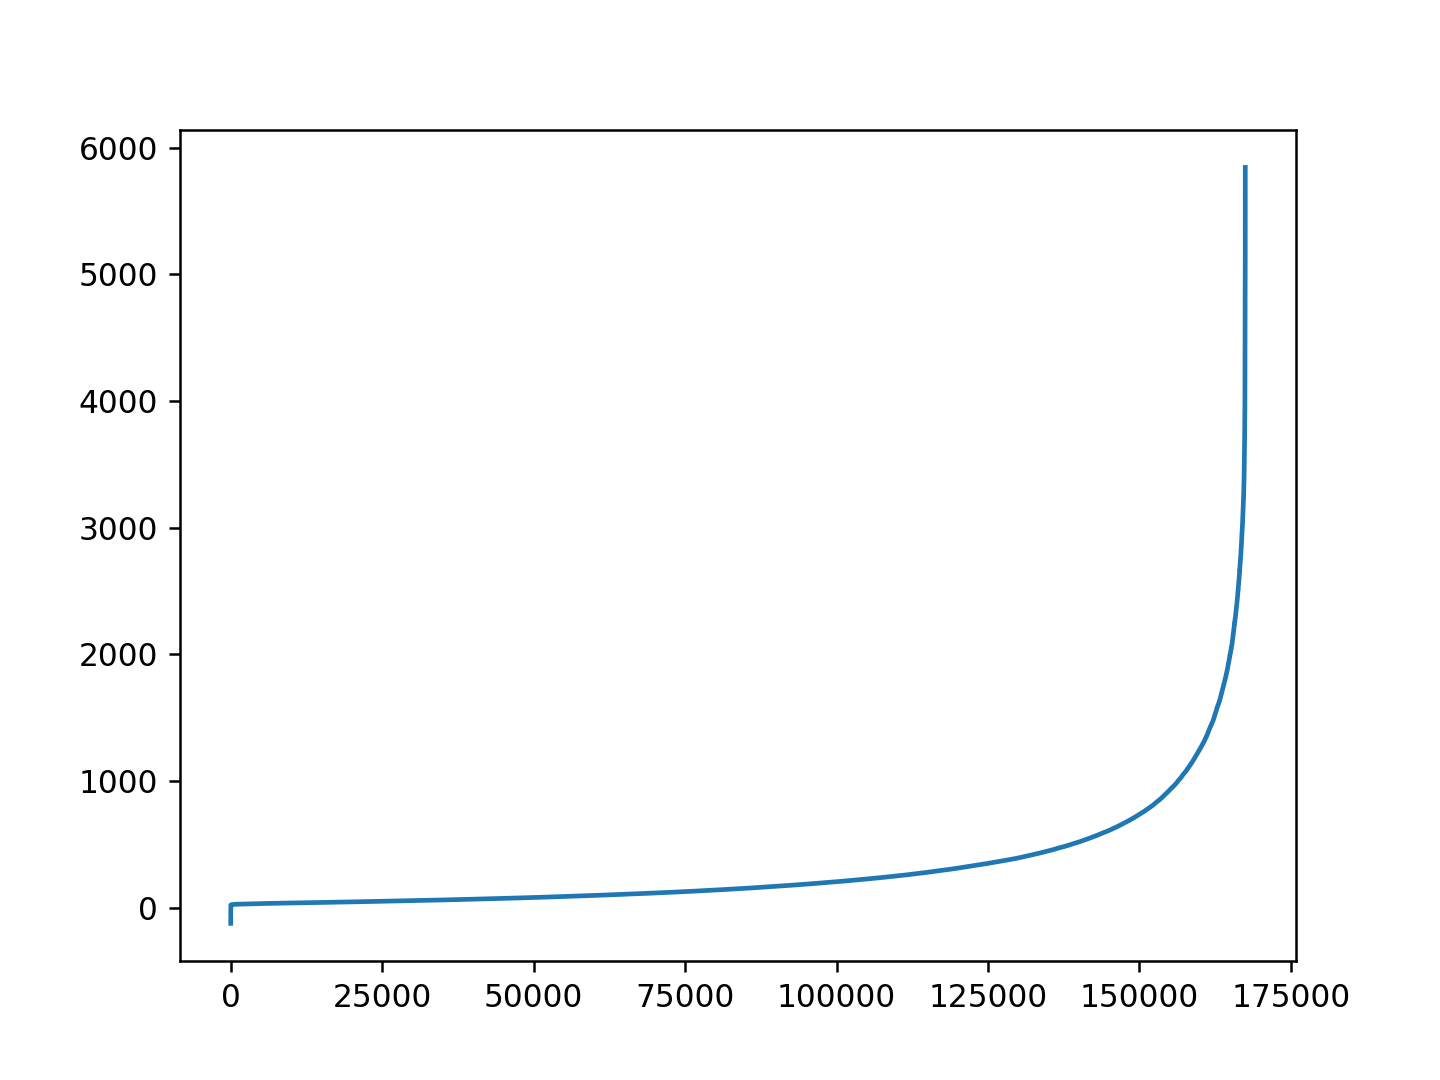

100


In [27]:
# convert waveform integrals to energy
gamma_waveform_channels=np.sum(gamma_baseline_data,axis=1)
gamma_waveform_energy=np.polyval(coeff,gamma_waveform_channels)

neutron_waveform_channels=np.sum(neutron_baseline_data,axis=1)
neutron_waveform_energy=np.polyval(coeff,neutron_waveform_channels)

#sort raw_data in order of ascending energy
gamma_sort_indices=np.argsort(gamma_waveform_energy)
gamma_waveform_energy=gamma_waveform_energy[gamma_sort_indices]

neutron_sort_indices=np.argsort(neutron_waveform_energy)
neutron_waveform_energy=neutron_waveform_energy[neutron_sort_indices]

#sort datasets
gamma_sorted_data=gamma_baseline_data[gamma_sort_indices]
neutron_sorted_data=neutron_baseline_data[neutron_sort_indices]

plt.figure("test")
plt.plot(neutron_waveform_energy)

print(len(neutron_hist_energies))

10


<IPython.core.display.Javascript object>


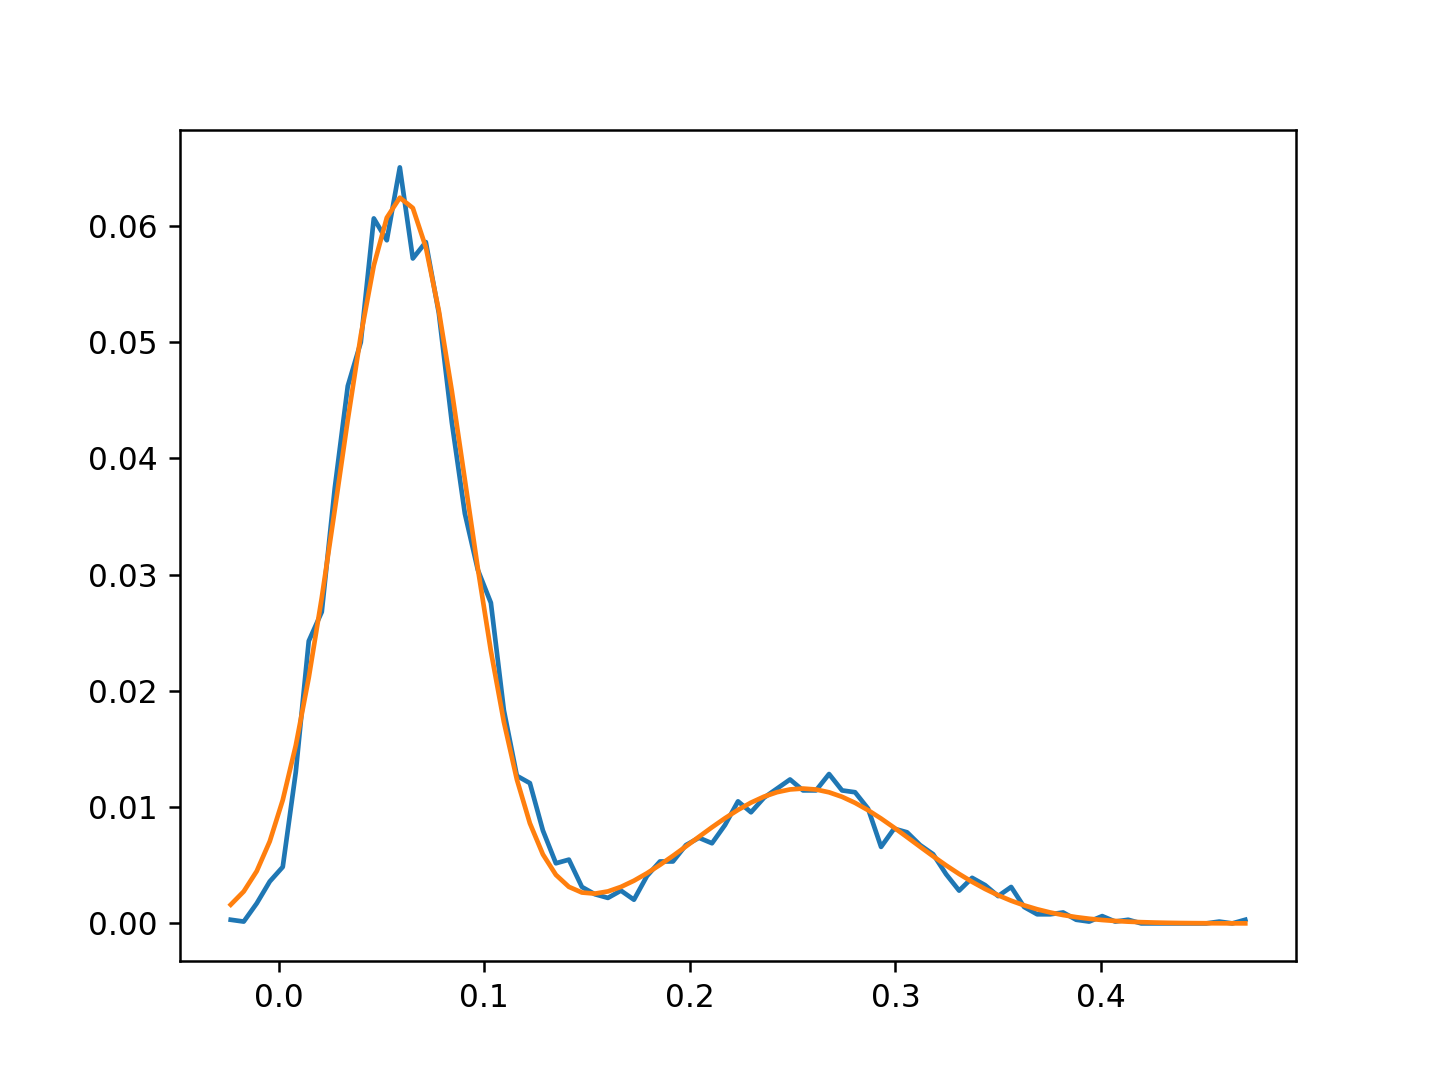

[0.980486045602621]
[0]
[0]
[0]


In [38]:
def gauss2(x,fwhm1,fwhm2,mu1,mu2,magnitude1,magnitude2):
    sigma1=fwhm1/2.355
    sigma2=fwhm2/2.355
    return magnitude1/(np.sqrt(2*np.pi)*sigma1)*np.exp(-0.5*(x-mu1)**2/sigma1**2)+magnitude2/(np.sqrt(2*np.pi)*sigma2)*np.exp(-0.5*(x-mu2)**2/sigma2**2)

energy_bins=np.hstack([np.array([0]),neutron_hist_energies[:]])
coarse_offsets=np.linspace(0,50,6)
best_offsets=[]
best_FoM=[]

for i in range(1,len(energy_bins)):
    lower_bound=neutron_waveform_energy>energy_bins[i-1]
    upper_bound=neutron_waveform_energy<energy_bins[i]
    mask=lower_bound==upper_bound
    
    binned_waveforms=neutron_sorted_data[mask]
    binned_energies=neutron_waveform_energy[mask]
    print(i)
    
    # need enough statistics, minimum limit arbitrarily chose
    if len(binned_waveforms)>500:
        coarse_FoM=[]
        fine_FoM=[]
        #iterate through coarse offsets first
        for j in range(0,len(coarse_offsets)):
            tail_total_ratios=[]
            # define peak maximum location as reference point
            waveform_peak_loc=np.argmax(binned_waveforms,axis=1)
            #iterate through each waveform
            for k in range(0,np.shape(binned_waveforms)[0]):
                waveform=binned_waveforms[k]
                #get each tail-to-total ratio
                front_integral=np.sum(waveform[0:int(waveform_peak_loc[k]+coarse_offsets[j])])
                tail_integral=np.sum(waveform[int(waveform_peak_loc[k]+coarse_offsets[j]):])
                
                tail_total_ratios.append(tail_integral/(tail_integral+front_integral))
            # create histogram of ratios     
            ratio_hist=np.histogram(tail_total_ratios,bins=int(np.floor(np.sqrt(np.shape(binned_waveforms)[0]))))
            ratio_values=ratio_hist[0]
            ratio_values=ratio_values/np.sum(ratio_values)
            ratio_bins=ratio_hist[1]
            ratio_bins=0.5*(ratio_bins[1:]+ratio_bins[:-1])
            # histogram should (if psd works for this energy) have two gaussian peaks
            # define initial guess, tuned to consistently get realistic results
            init_guess=[(np.max(ratio_bins)-np.min(ratio_bins))/2,(np.max(ratio_bins)-np.min(ratio_bins))/2,ratio_bins[np.argmax(ratio_values)],ratio_bins[len(ratio_values)-np.argmax(ratio_values)-1],0.5,0.5]
            # define boundaries, such that initial guess is always valid
            upper_bound=[np.max(ratio_bins)-np.min(ratio_bins),np.max(ratio_bins)-np.min(ratio_bins),np.max(ratio_bins),np.max(ratio_bins),1,1]
            lower_bound=[0,0,np.min(ratio_bins),np.min(ratio_bins),0,0]
            fit_bounds=[lower_bound,upper_bound]
            
#             plt.figure("coarse test")
#             plt.plot(ratio_bins,ratio_values)
            
            # calculate gaussian characteristics, if fails for whatever reason set FoM to zero for that offset
            try:
                popt,_=curve_fit(gauss2,ratio_bins,ratio_values,p0=init_guess,bounds=fit_bounds)
#                 plt.plot(ratio_bins,gauss2(ratio_bins,*popt))
            except:
                popt=np.array([0,0,0,0,0,0])
            # set FoM to zero if one Gaussian is very small
            # otherwise, calculate FoM
            if popt[4]<0.001 or popt[5]<0.001 or popt[2]<0 or popt[3]<0:
                coarse_FoM.append(0)
            else: 
                coarse_FoM.append(np.abs(popt[2]-popt[3])/(popt[0]+popt[1]))
        #pull the best coarse offset found
        best_coarse_offset=coarse_offsets[np.argmax(coarse_FoM)]
        #define fine offsets as closest 10 to either side of best coarse offset
        if best_coarse_offset!=0:
            fine_offsets=np.arange(best_coarse_offset-10,best_coarse_offset+10)
        else:
            fine_offsets=np.arange(0,10)
        # find best offset, similar to coarse offset process
        for j in range(0,len(fine_offsets)):
            tail_total_ratios=[]
            waveform_peak_loc=np.argmax(binned_waveforms,axis=1)
            for k in range(0,np.shape(binned_waveforms)[0]):
                waveform=binned_waveforms[k]
                front_integral=np.sum(waveform[0:int(waveform_peak_loc[k]+fine_offsets[j])])
                tail_integral=np.sum(waveform[int(waveform_peak_loc[k]+fine_offsets[j]):])
                
                tail_total_ratios.append(tail_integral/(tail_integral+front_integral))
                 
            ratio_hist=np.histogram(tail_total_ratios,bins=int(np.floor(np.sqrt(np.shape(binned_waveforms)[0]))))
            ratio_values=ratio_hist[0]
            ratio_values=ratio_values/np.sum(ratio_values)
            ratio_bins=ratio_hist[1]
            ratio_bins=0.5*(ratio_bins[1:]+ratio_bins[:-1])
            init_guess=[(np.max(ratio_bins)-np.min(ratio_bins))/2,(np.max(ratio_bins)-np.min(ratio_bins))/2,ratio_bins[np.argmax(ratio_values)],ratio_bins[len(ratio_values)-np.argmax(ratio_values)-1],0.5,0.5]
            upper_bound=[np.max(ratio_bins)-np.min(ratio_bins),np.max(ratio_bins)-np.min(ratio_bins),np.max(ratio_bins),np.max(ratio_bins),1,1]
            lower_bound=[0,0,np.min(ratio_bins),np.min(ratio_bins),0,0]
            fit_bounds=[lower_bound,upper_bound]
#             plt.figure("fom test")
#             plt.plot(ratio_bins,ratio_values)
            try:
                popt,_=curve_fit(gauss2,ratio_bins,ratio_values,p0=init_guess,bounds=fit_bounds)
#                 plt.plot(ratio_bins,gauss2(ratio_bins,*popt))
#                 print(popt)
            except:
                popt=np.array([0,0,0,0,0,0])
            if popt[4]<0.001 or popt[5]<0.001 or popt[2]<0 or popt[3]<0:
                fine_FoM.append(0)
            else: 
                fine_FoM.append(np.abs(popt[2]-popt[3])/(popt[0]+popt[1]))
            break
        best_fine_offset=fine_offsets[np.argmax(fine_FoM)]
        best_offsets.append(best_fine_offset)
        best_FoM.append(np.max(fine_FoM))
        
    else: 
        best_offsets.append(8)
        best_FoM.append(0)
print(coarse_FoM)
print(fine_FoM)
print(best_offsets)  
print(best_FoM)

<IPython.core.display.Javascript object>


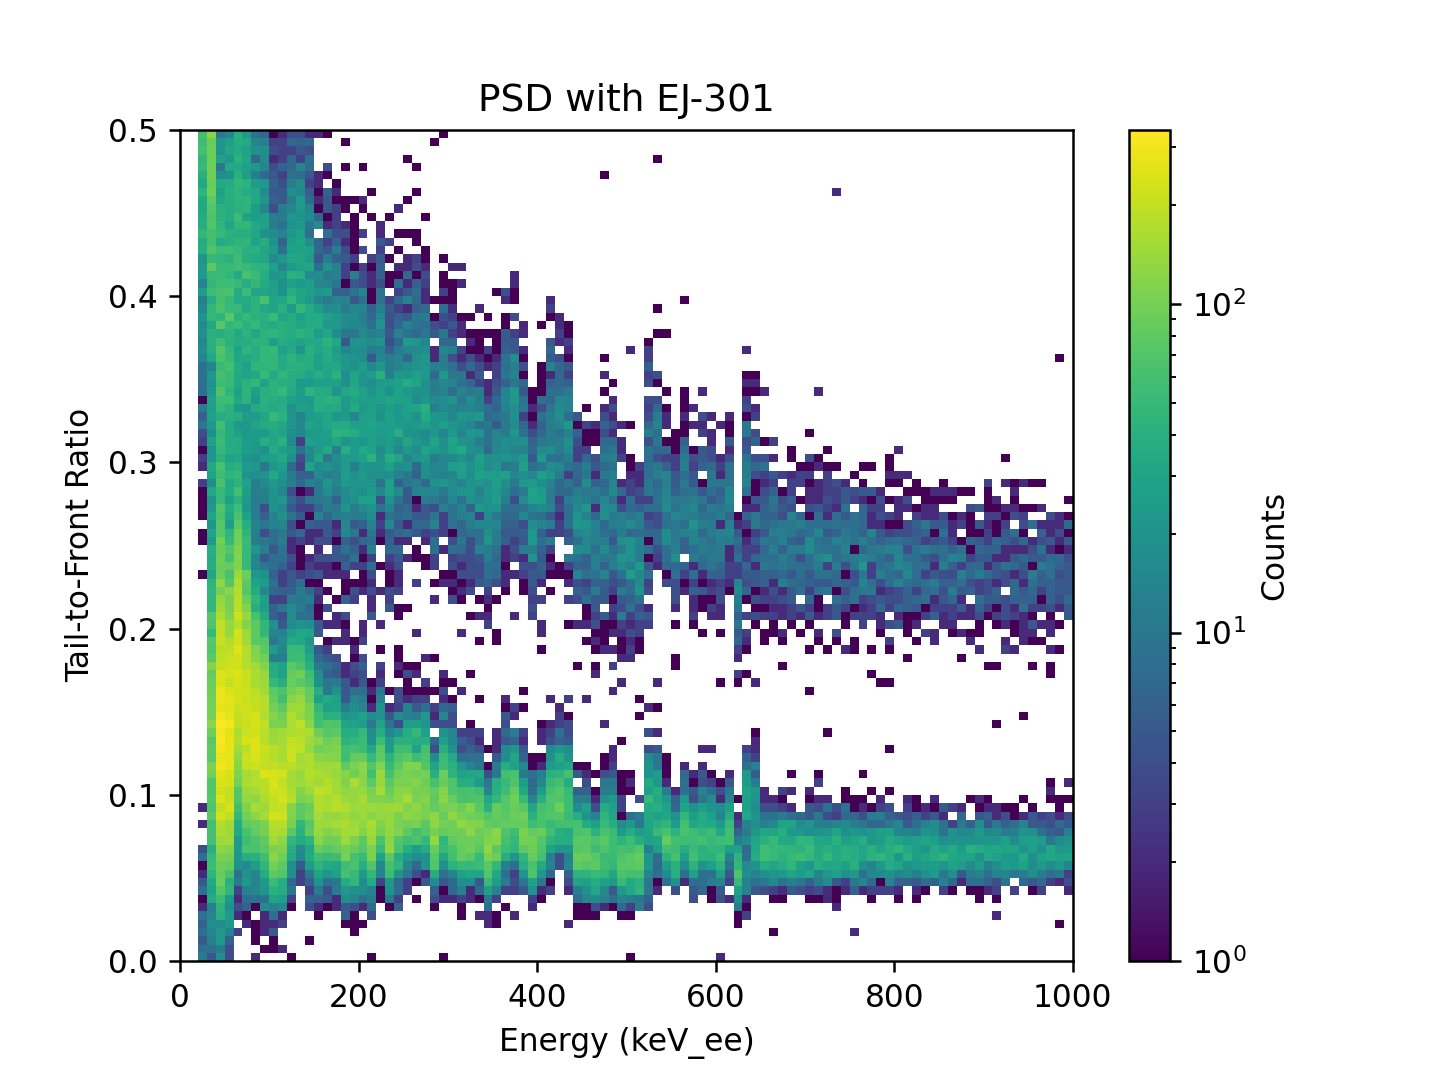

Text(0.5, 1.0, 'PSD with EJ-301')

In [29]:
tail_peak_ratios=[]
waveform_energies=[]
waveform_peak_locs=np.argmax(neutron_sorted_data,axis=1)
for i in range(1,len(energy_bins)):

    lower_bound=neutron_waveform_energy>energy_bins[i-1]
    upper_bound=neutron_waveform_energy<energy_bins[i]
    mask=lower_bound==upper_bound
    
    binned_waveforms=neutron_sorted_data[mask]
    binned_peak_loc=waveform_peak_locs[mask]
    
    offset=best_offsets[i-1]
    for j in range(0,np.shape(binned_waveforms)[0]):
        waveform=binned_waveforms[j]
        waveform_channel=np.sum(waveform)
        waveform_energies.append(np.polyval(coeff,waveform_channel))
        waveform_peak_loc=binned_peak_loc[j]
        
        front_integral=np.sum(waveform[0:int(waveform_peak_loc+offset)])
        tail_integral=np.sum(waveform[int(waveform_peak_loc+offset):])
        tail_peak_ratios.append(tail_integral/(tail_integral+front_integral))
plt.figure("Ratio v. Energy w Best Offsets")
ratio_histogram=plt.hist2d(waveform_energies,tail_peak_ratios,range=[[0,1000],[0,0.5]],bins=100,norm=colors.LogNorm())
cbar=plt.colorbar()
cbar.set_label("Counts")
plt.xlabel ("Energy (keV_ee)")
plt.ylabel("Tail-to-Front Ratio")
plt.title("PSD with EJ-301")

<IPython.core.display.Javascript object>


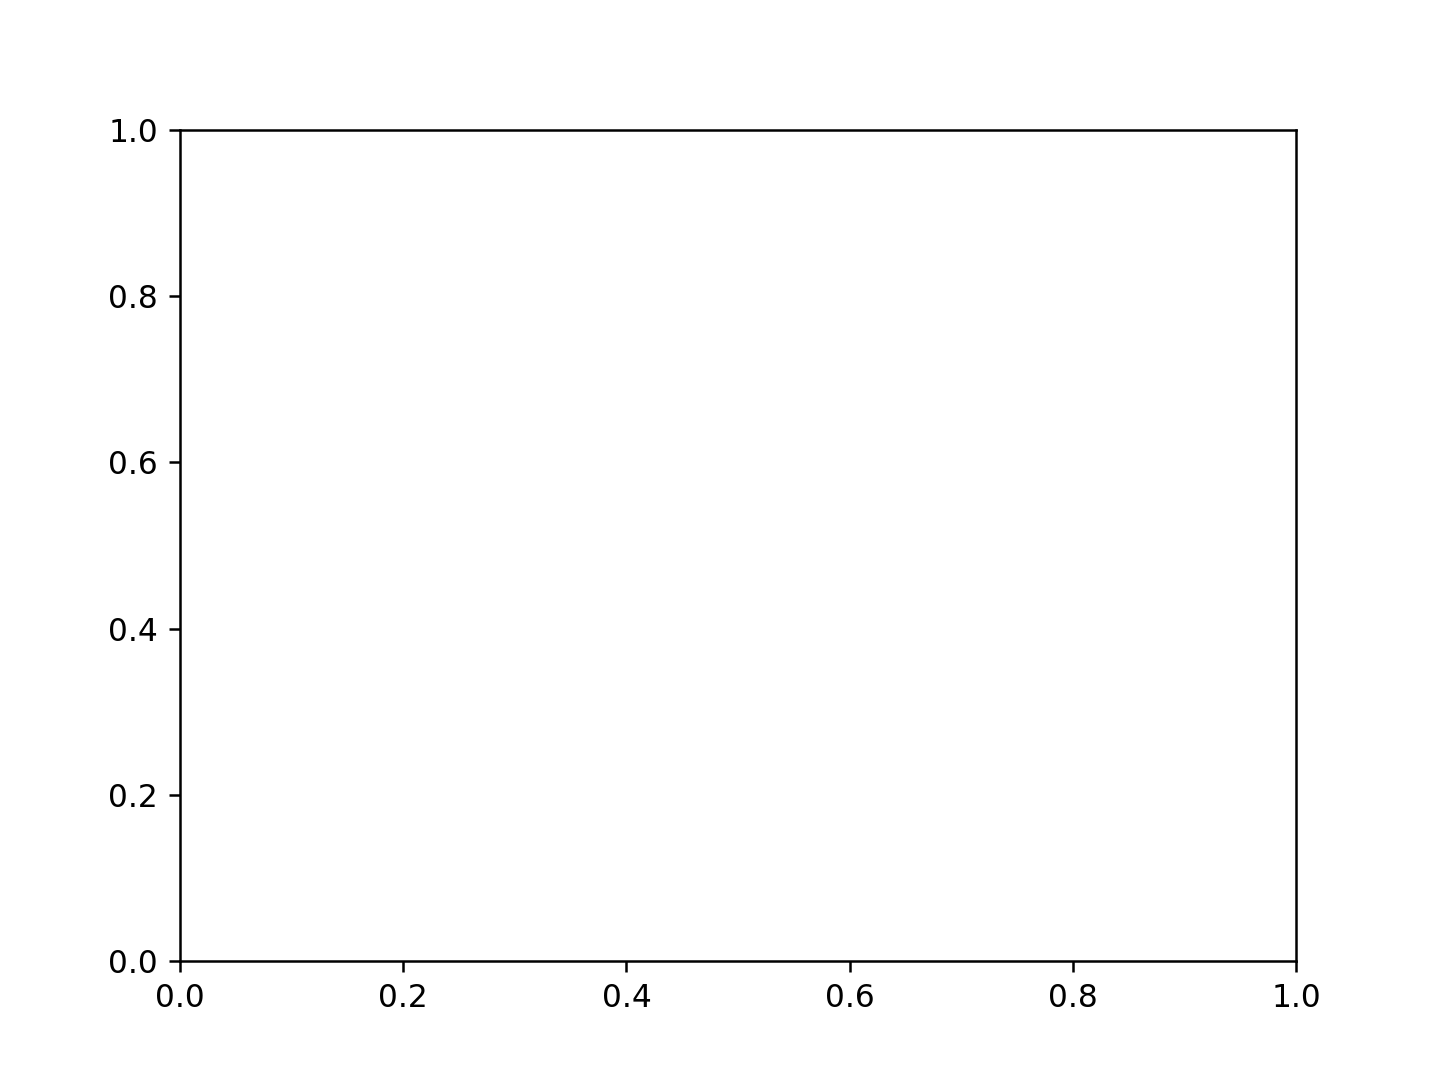

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

In [39]:
plt.figure("Best FoM Found")
plt.plot(neutron_hist_energies,best_FoM)
plt.xlabel("Energy (keV_ee)")
plt.ylabel("Figure of Merit (no units)")
plt.figure("Best Offset")
plt.plot(best_offsets)

(242162, 100)
(242162,)
(242162,)


<IPython.core.display.Javascript object>


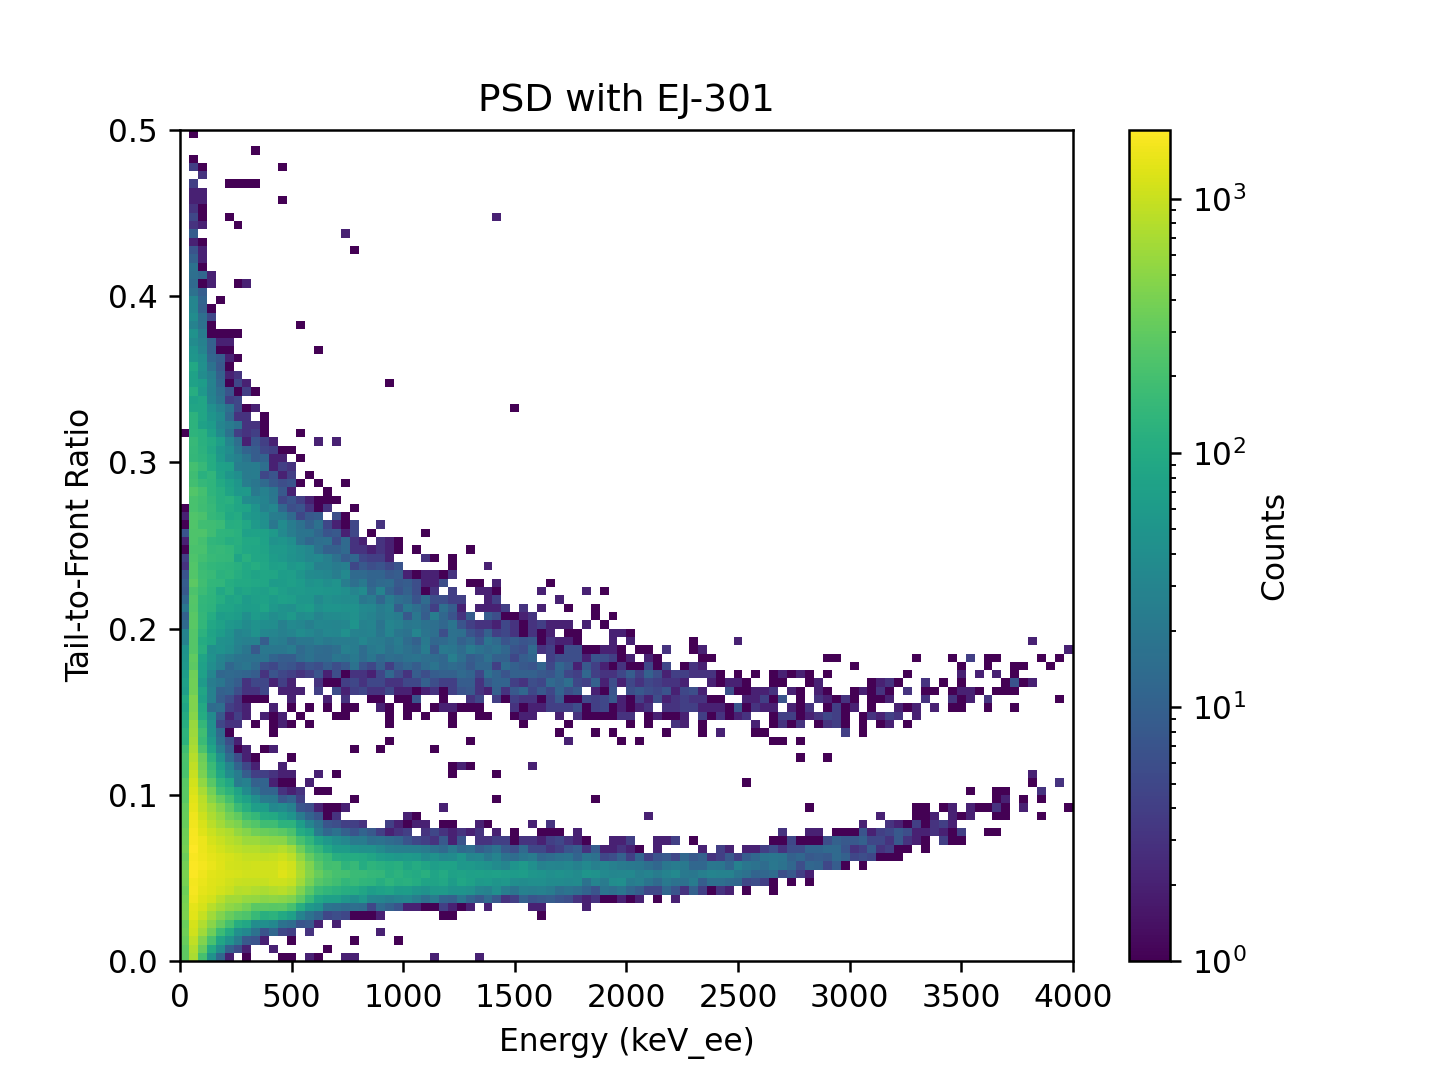

In [17]:
#define optimal offset for gaussian separation
offset=10

#get peak locations
gamma_peak_loc=np.argmax(gamma_sorted_data,axis=1)
neutron_peak_loc=np.argmax(neutron_sorted_data,axis=1)

#iterate through each energy bin and get peak gaussians
bin_width=(gamma_hist_energies[1]-gamma_hist_energies[0])/2

# for i in range(0,np.size(gamma_hist_energies)):
#     mask=np.abs(gamma_waveform_energy-gamma_hist_energies[i])<=bin_width
#     binned_gamma_waveforms=gamma_sorted_data[mask]
#     mask=np.abs(neutron_waveform_energy-gamma_hist_energies[i])<=bin_width
#     binned_neutron_waveforms=neutron_sorted_data[mask]
    
    
# #     if i==5:
# #         print(gamma_hist_energies[i])
# #         plt.figure("test2")
# #         #plt.plot(np.sum(binned_gamma_waveforms,axis=1)*coeff[0]+coeff[1])
# #         plt.plot(np.sum(binned_neutron_waveforms,axis=1)*coeff[0]+coeff[1])
#     if np.size(binned_gamma_waveforms)!=0 && np.size(binned_gamma_waveforms)!=0:
        
#     else:

combined_data=np.vstack([gamma_sorted_data,neutron_sorted_data])
combined_energy=np.hstack([gamma_waveform_energy,neutron_waveform_energy])
combined_peak_loc=np.hstack([gamma_peak_loc,neutron_peak_loc])
print(np.shape(combined_data))
print(np.shape(combined_energy))
print(np.shape(combined_peak_loc))
energy=[]
tail_peak_ratio=[]
for i in range(0,np.shape(combined_data)[0]):
    energy.append(combined_energy[i])
    waveform=combined_data[i]
    peak_integral=np.sum(waveform[0:combined_peak_loc[i]+offset])
    tail_integral=np.sum(waveform[combined_peak_loc[i]+offset:])
    tail_peak_ratio.append(tail_integral/(peak_integral+tail_integral))
    
    

plt.figure("Ratio v. Energy")
ratio_histogram=plt.hist2d(energy,tail_peak_ratio,range=[[0,4000],[0,0.5]],bins=100,norm=colors.LogNorm())
cbar=plt.colorbar()
cbar.set_label("Counts")
plt.xlabel ("Energy (keV_ee)")
plt.ylabel("Tail-to-Front Ratio")
plt.title("PSD with EJ-301")

ratio_values=ratio_histogram[0]
xedges=ratio_histogram[1]
yedges=ratio_histogram[2]

<IPython.core.display.Javascript object>


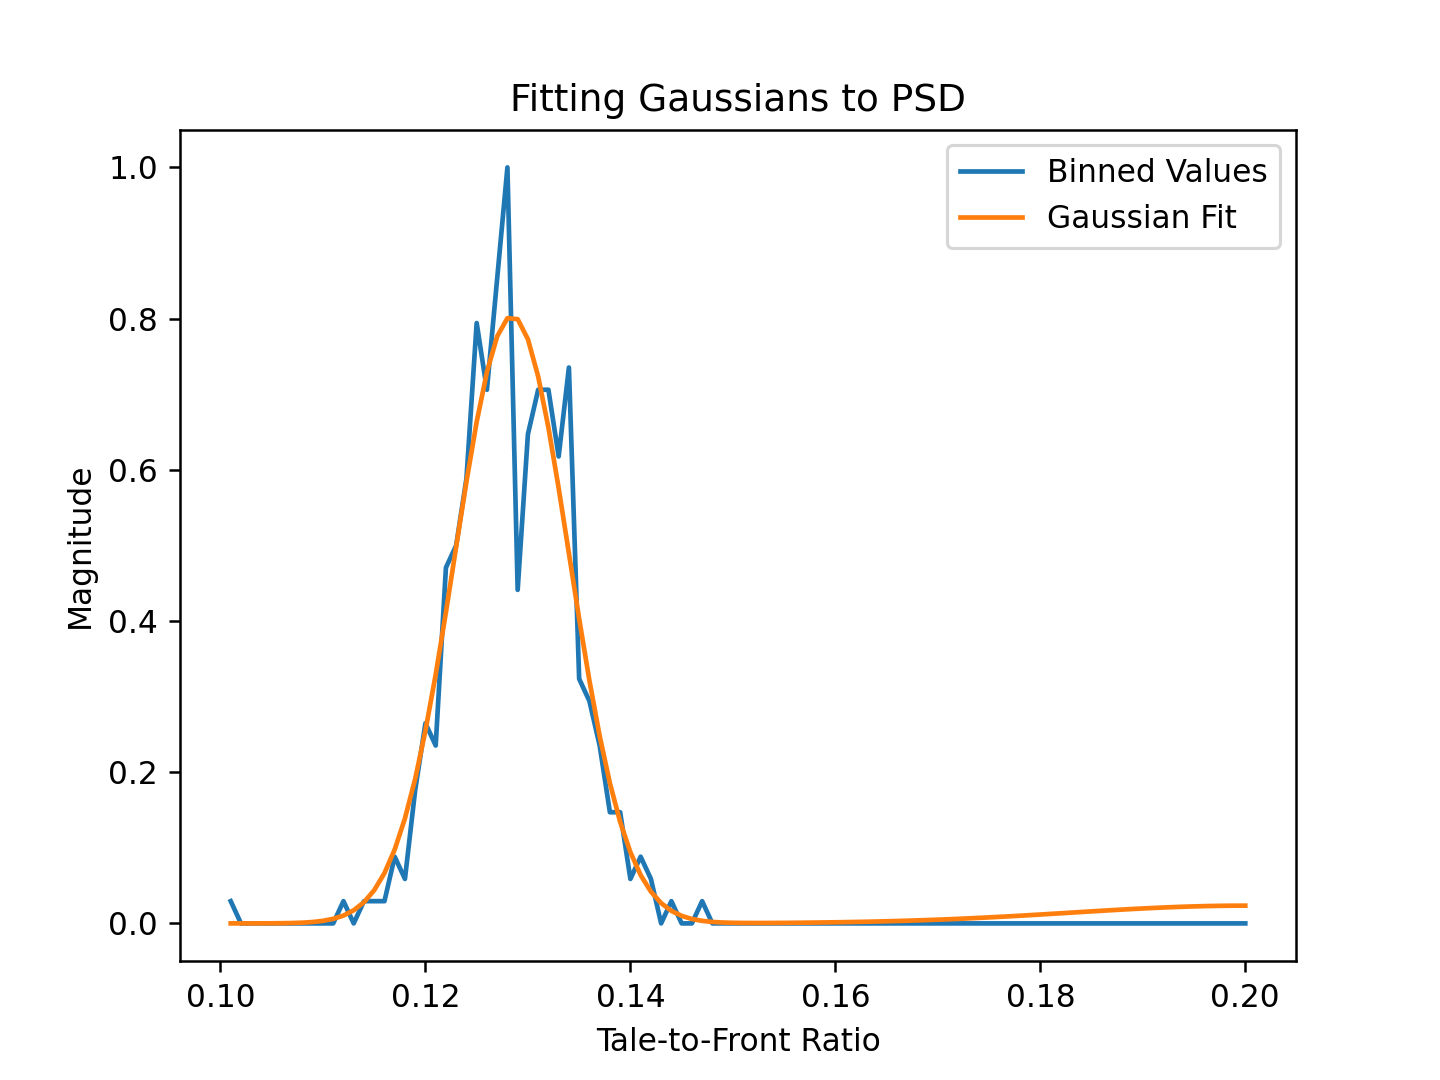

C:\Users\oscma\AppData\Local\Temp\ipykernel_45084\503621410.py:11: RuntimeWarning: invalid value encountered in true_divide
  distribution=distribution/np.max(distribution)


In [18]:
FoM=[]
ratio_bins=0.5*(yedges[1:]+yedges[-1:])
def gauss2(x,fwhm1,fwhm2,mu1,mu2,magnitude1,magnitude2):
    sigma1=fwhm1/2.355
    sigma2=fwhm2/2.355
    return magnitude1/(np.sqrt(2*np.pi)*sigma1)*np.exp(-0.5*(x-mu1)**2/sigma1**2)+magnitude2/(np.sqrt(2*np.pi)*sigma2)*np.exp(-0.5*(x-mu2)**2/sigma2**2)


for i in range(0,np.shape(ratio_values)[0]):
    distribution=ratio_values[i]
    distribution=distribution/np.max(distribution)
    
    #20 bounds (0.001,[0.04,0.04,0.2,0.2,1,1]), p0 [0.015,0.015,0.125,0.17,1,0.1]
    try:
        popt,_=curve_fit(gauss2,ratio_bins,distribution,p0=[0.015,0.015,0.125,0.17,1,0.1],bounds=(0.001,[0.04,0.04,0.2,0.2,1,1]))
        if i==15:
            plt.figure("Test fom")
            plt.plot(ratio_bins,distribution)
            plt.plot(ratio_bins,gauss2(ratio_bins,*popt))
            plt.xlabel("Tale-to-Front Ratio")
            plt.ylabel("Magnitude")
            plt.legend(["Binned Values","Gaussian Fit"])
            plt.title("Fitting Gaussians to PSD")
            
        
        cutoff=np.min(distribution)
        if gauss2(popt[2],*popt)<2*cutoff or gauss2(popt[3],*popt)<2*cutoff or popt[2]<0 or popt[3]<0:
            
            FoM.append(0)
        else:
            FoM.append(np.abs(popt[2]-popt[3])/(np.abs(popt[0])+np.abs(popt[1])))
            
    except:
        FoM.append(0)

<IPython.core.display.Javascript object>


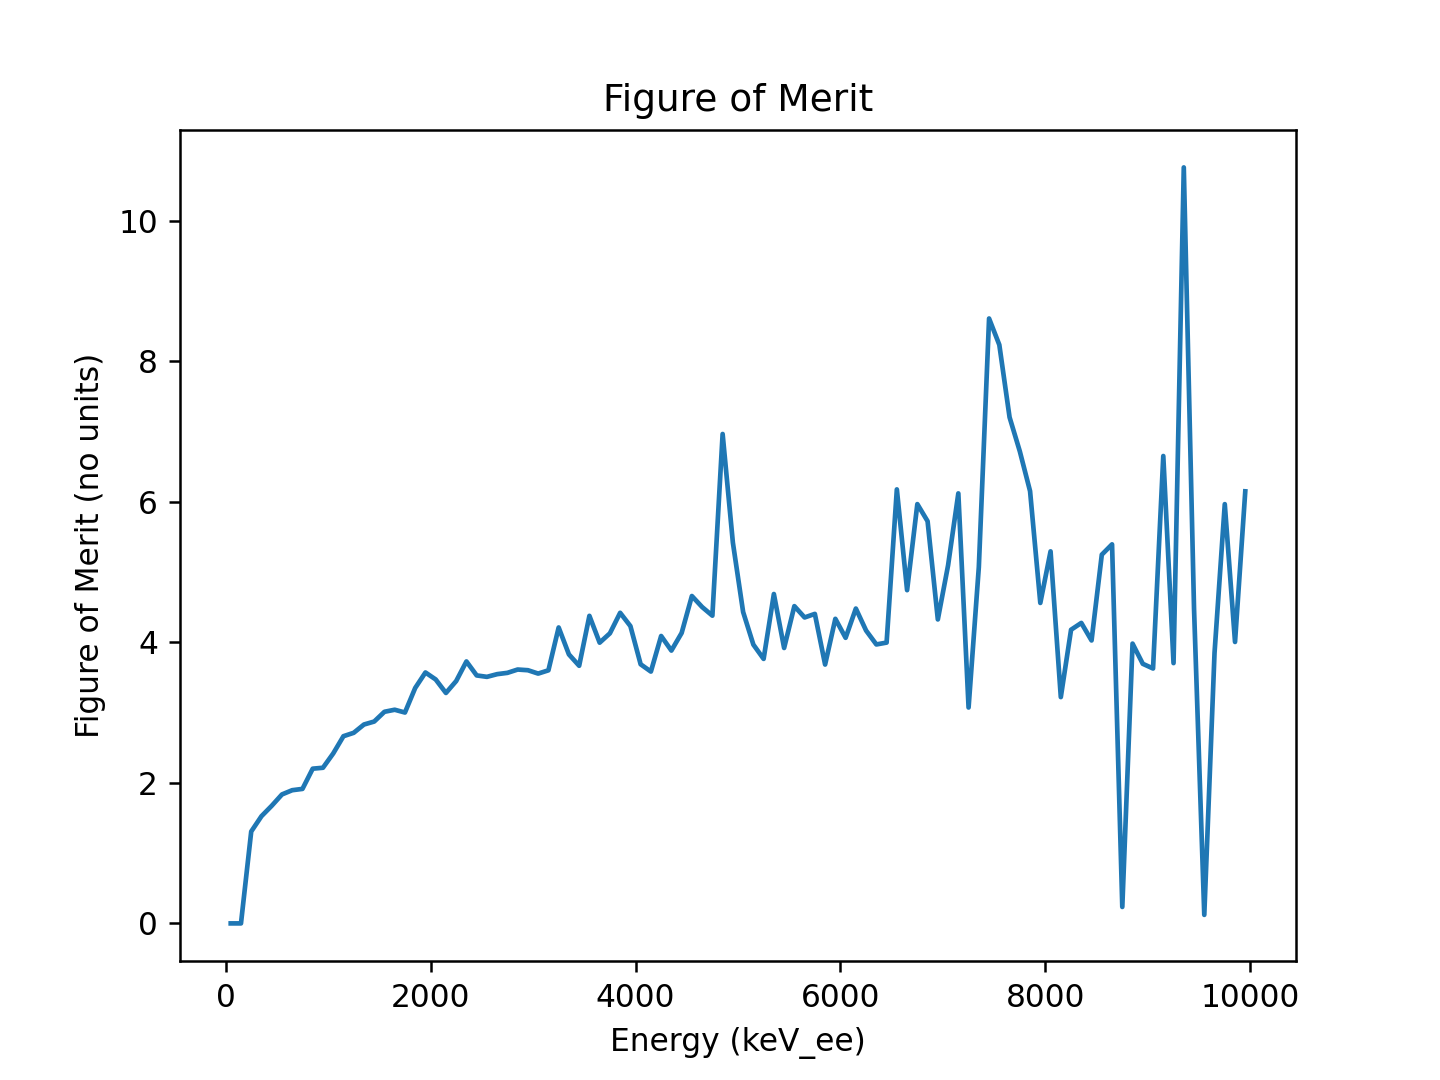

Text(0, 0.5, 'Figure of Merit (no units)')

In [88]:
FoM_energies=0.5*(xedges[1:]+xedges[:-1])
FoM[0]=0
FoM[1]=0

plt.figure("Figure of Merit")
plt.plot(FoM_energies,FoM)
plt.title("Figure of Merit")
plt.xlabel("Energy (keV_ee)")
plt.ylabel("Figure of Merit (no units)")


# def log_fit(x,base,magnitude,multiplier,constant2):
#     return magnitude*np.log((multiplier*x))+constant2
# popt,_=curve_fit(log_fit,FoM_energies,FoM)
# plt.plot(FoM_energies,log_fit(FoM_energies,*popt))



<IPython.core.display.Javascript object>


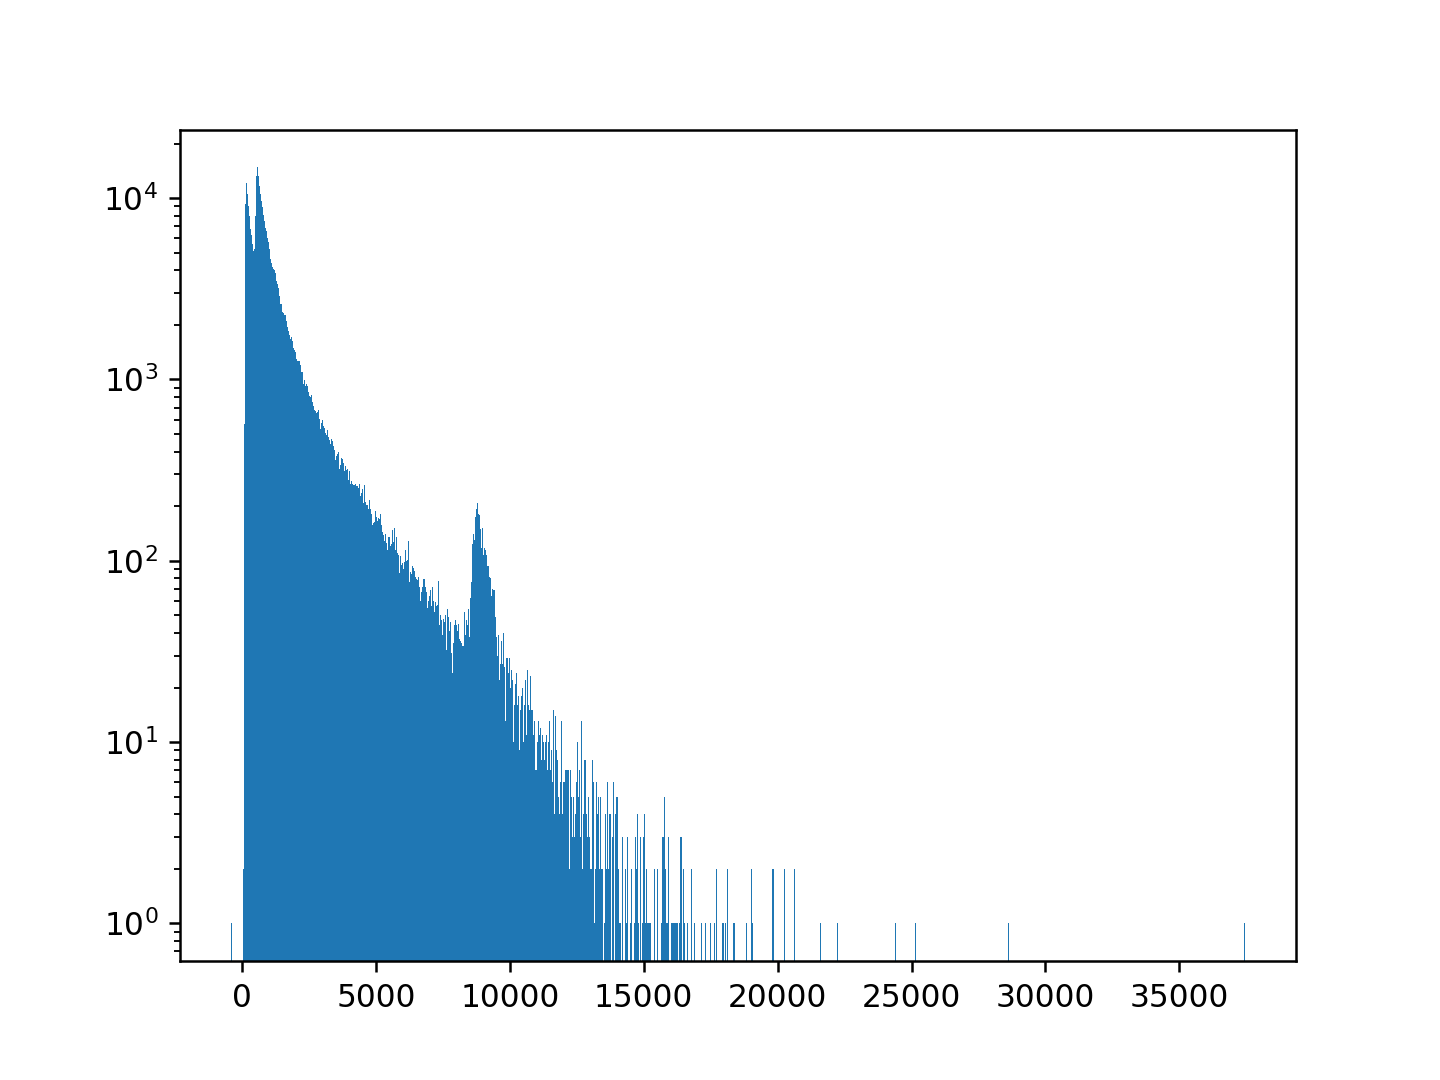

In [38]:
plt.figure("test energies")
plt.hist(energy,bins=1000)
plt.yscale("log")

In [ ]:
#iterate through each bin in histogram

<IPython.core.display.Javascript object>


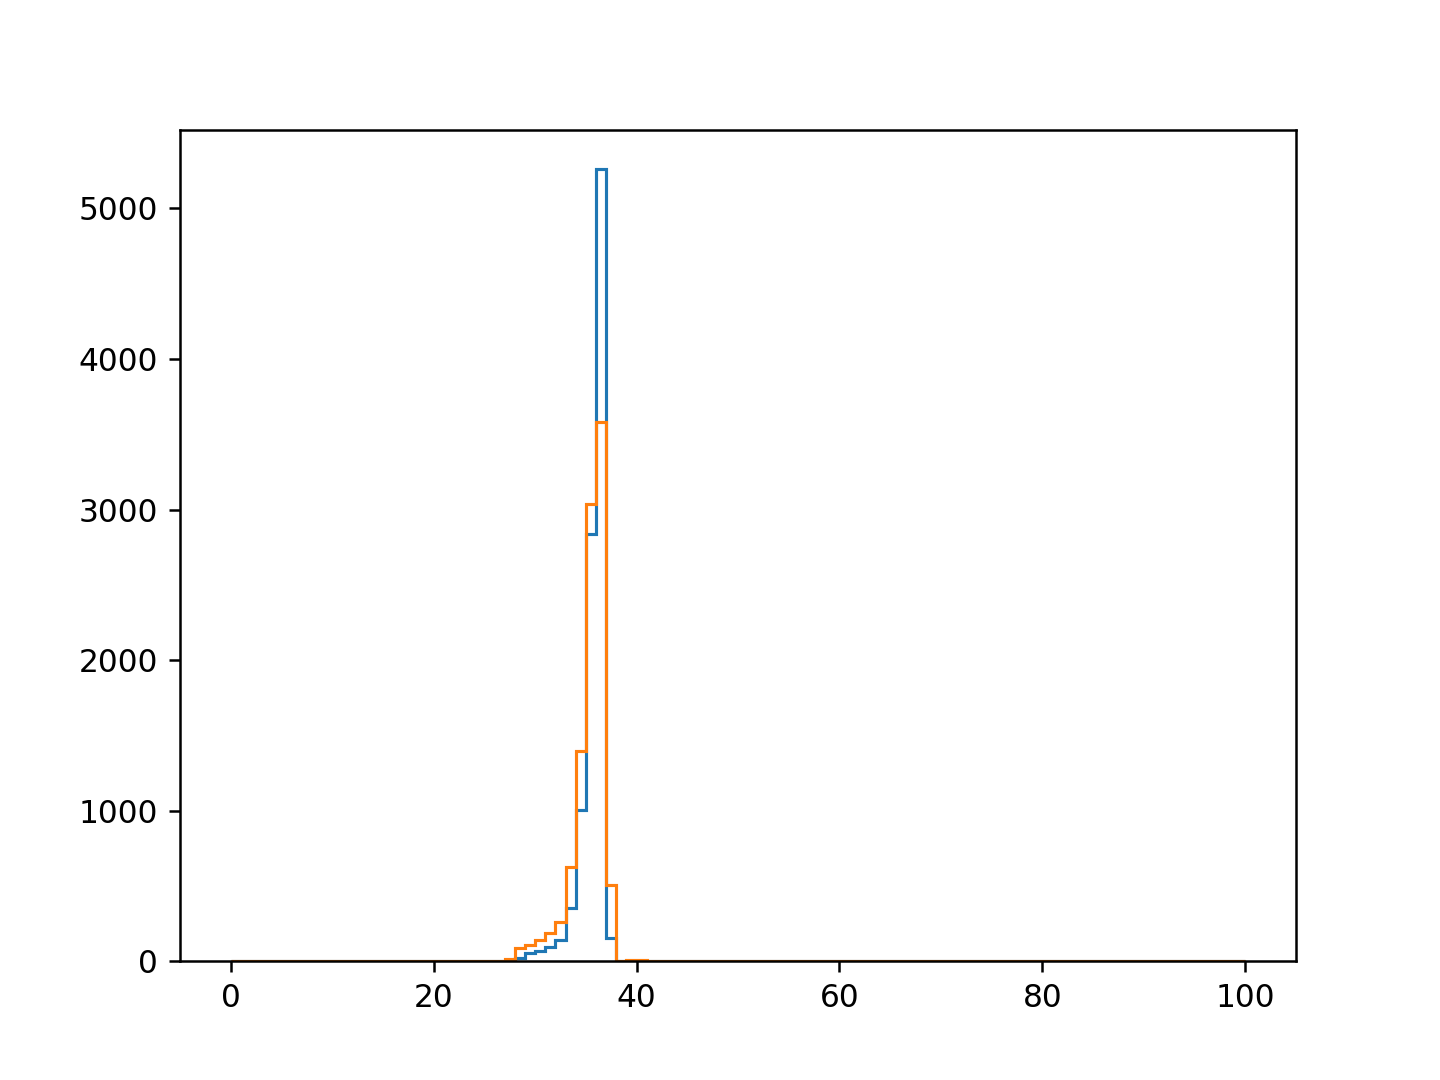

In [134]:
gamma_peak_locations=np.argmax(gamma_baseline_data,axis=1)
neutron_peak_locations=np.argmax(neutron_baseline_data,axis=1)
plt.figure("Gamma Peak Locations")
_=plt.hist(gamma_peak_locations,bins=100,range=[0,100],histtype='step')
_=plt.hist(neutron_peak_locations,bins=100,range=[0,100],histtype='step')

In [147]:
offset=5

In [148]:
#find area under waveforms before and after waveform peaks
gamma_ratios=[]
for i in range(0,100):
    before_peak=np.trapz(gamma_threshold_data[i][0:gamma_peak_locations[i]+offset])
    after_peak=np.trapz(gamma_threshold_data[i][gamma_peak_locations[i]+offset:])
    gamma_ratios.append(after_peak/before_peak)

In [149]:
neutron_ratios=[]
for i in range(0,100):
    before_peak=np.trapz(neutron_threshold_data[i][0:neutron_peak_locations[i]+offset])
    after_peak=np.trapz(neutron_threshold_data[i][neutron_peak_locations[i]+offset:])
    neutron_ratios.append(after_peak/before_peak)

<IPython.core.display.Javascript object>


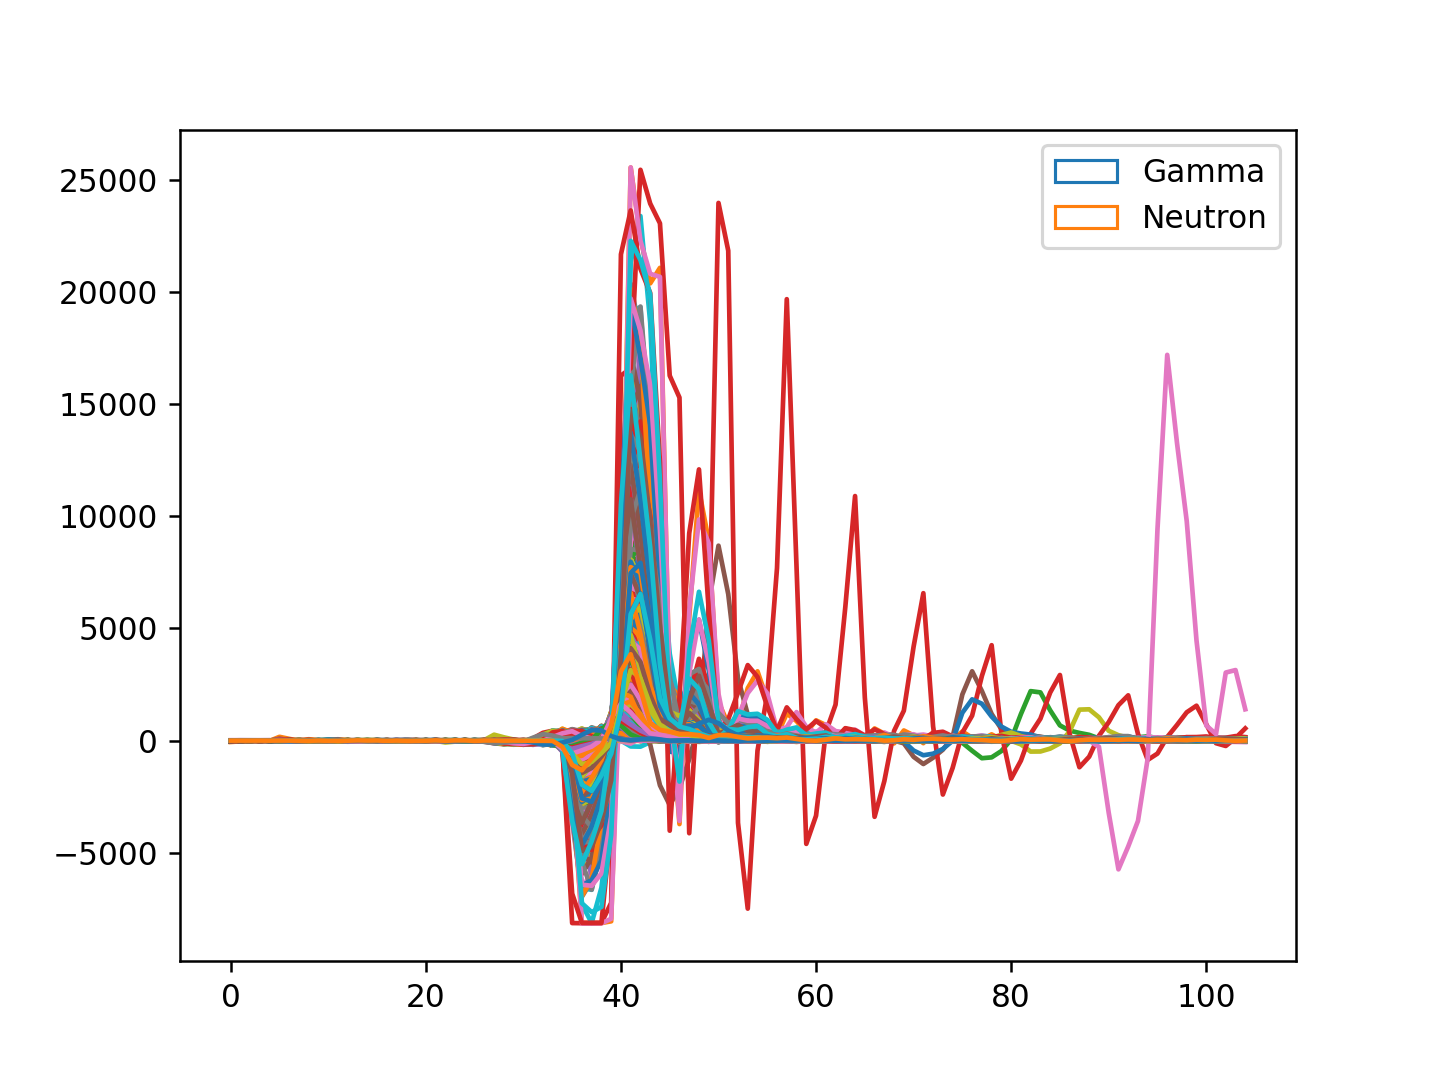

In [150]:
plt.figure("Ratio Comparisons")
_=plt.hist(gamma_ratios,bins=100,histtype='step',range=[0,1])
_=plt.hist(neutron_ratios,bins=100,histtype='step',range=[0,1])
plt.legend(["Gamma","Neutron"])

<IPython.core.display.Javascript object>


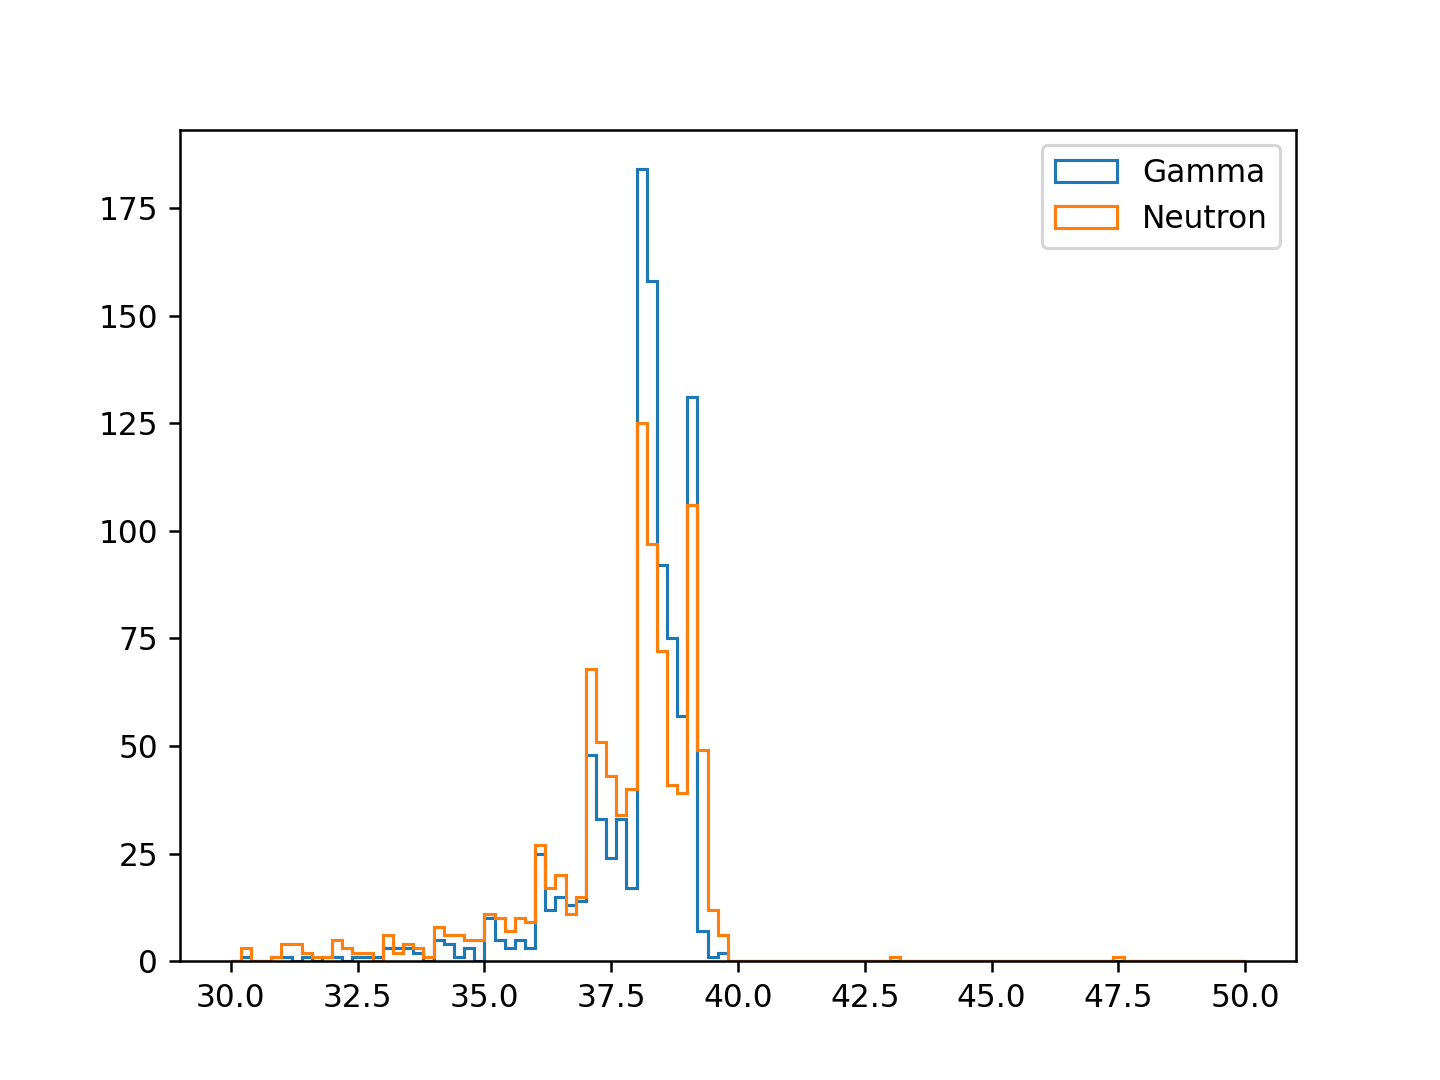

In [151]:
#constant fraction discrimination
delay=5
factor=3
gamma_waveform_peak_loc=[]

for i in range(0,1000):
    pulse=gamma_baseline_data[i]
    delay_zeros=np.zeros(delay)
    delayed_pulse=np.hstack([delay_zeros,pulse])*factor
    inverted_pulse=np.hstack(([pulse,delay_zeros]))*-1
    summed_pulse=np.add(inverted_pulse,delayed_pulse)
    plt.plot(summed_pulse)
    min_loc=np.argmin(summed_pulse)
    for j in range(min_loc,999999999999):
        if summed_pulse[j+1]>0:
            gamma_waveform_peak_loc.append(j+1/(1-summed_pulse[j+1]/summed_pulse[j]))
            break

neutron_waveform_peak_loc=[]
for i in range(0,1000):
    pulse=neutron_baseline_data[i]
    delay_zeros=np.zeros(delay)
    delayed_pulse=np.hstack([delay_zeros,pulse])*factor
    inverted_pulse=np.hstack(([pulse,delay_zeros]))*-1
    summed_pulse=np.add(inverted_pulse,delayed_pulse)
    plt.plot(summed_pulse)
    min_loc=np.argmin(summed_pulse)
    for j in range(min_loc,999999999999):
        if summed_pulse[j+1]>0:
            neutron_waveform_peak_loc.append(j+1/(1-summed_pulse[j+1]/summed_pulse[j]))
            break
            
plt.figure("CFD")
_=plt.hist(gamma_waveform_peak_loc,bins=100,histtype='step',range=[30,50])
_=plt.hist(neutron_waveform_peak_loc,bins=100,histtype='step',range=[30,50])
plt.legend(["Gamma","Neutron"])

<IPython.core.display.Javascript object>


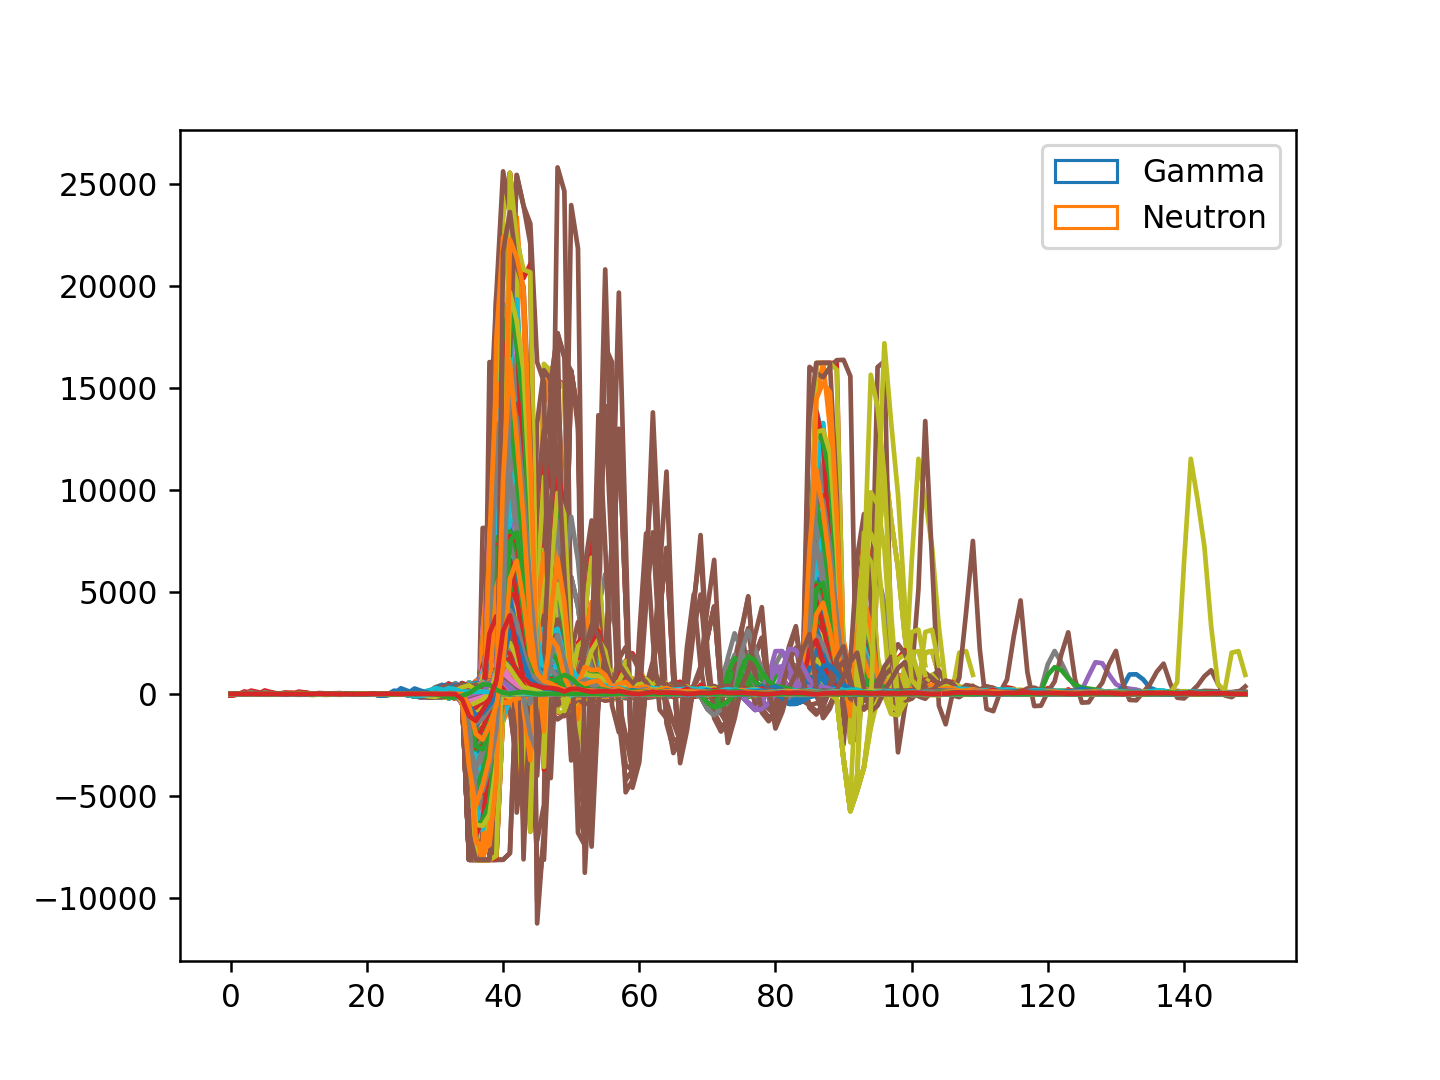

In [118]:
plt.figure("CFD Comparison")
_=plt.hist(gamma_waveform_peak_loc,bins=100,histtype='step',range=[0,100])
_=plt.hist(neutron_waveform_peak_loc,bins=100,histtype='step',range=[0,100])
plt.legend(["Gamma","Neutron"])

In [118]:
x=np.array([1,2,3,4,5,6])
mask=np.abs(3-x)<2
x[mask]

array([2, 3, 4])